In [2]:
import tensorflow as tf
import numpy as np
from tensorflow import keras

- 대부분의 문제는 tf.keras로 해결 가능할 것이지만, 이번에는 저수준 API를 살펴보자
- 나만의 손실함수, 지표, 층 , 모델, 초기화, 규제, 가중치 규제 등을 만들어 세부적으로 제어할 필요가 있음

# 12.1. 텐서플로 살펴보기
- 넘파이와 핵심 구조가 매우 비슷하나 GPU를 지원함
- 분산 컴퓨팅을 지원함
- 일종의 Just in time 컴파일러를 포함하여 속도를 높이고 메모리 사용량을 줄이기 위해 계산을 최적화함
    - 이를 위해 파이썬 함수에서 계산 그래프를 추출한 다음 최적화(일종의 pruning), 효율적으로 실행
- 계산 그래프는 플랫폼 중립 포맷으로 보낼 수 있으므로, 여러 OS의 장치에서 실행가능함
- 자동 미분(autodiff)과 RMSProp, Nadam과 같은 고속 옵티마이저를 제공함

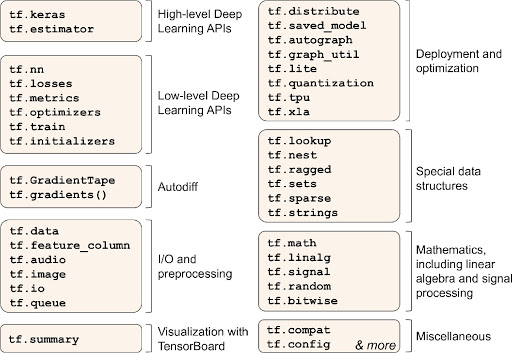
- https://lh3.googleusercontent.com/proxy/fqQeDC2OyfiBf4ScRKhsDQ175jtZsrYiMUq_oRz4x9xwxDoRSaeholoWnl3oXIt8Y8D3zVIK2cG0Nu7yPfZiY9WpdbT9vGOvgDss8g7U91shq5EqAfXk5iXh6PNNlzPKyC2oOeoH_kn2bQwoHa1fng

- 대부분의 코드는 고수준 API로 이루어지지만, 자유도를 부여해야하는 경우 저수준 API를 이용해서 직접 텐서를 다뤄야함
- 대다수 연산은 커널이라 부르는 여러 구현을 가지며, 각 커널은 CPU, GPU, TPU와 같은 특정 장치에 맞춰 만들어져서, 속도를 극적으로 증가시킬 수 있음

# 12.2. 넘파이처럼 텐서플로 사용하기

### 12.2.1. 텐서와 연산
- tf.constant로 텐서를 생성

In [5]:
tf.constant([[1., 2., 3.], [4., 5., 6.]]), np.array([[1., 2., 3.], [4., 5., 6.]])

(<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
 array([[1., 2., 3.],
        [4., 5., 6.]], dtype=float32)>,
 array([[1., 2., 3.],
        [4., 5., 6.]]))

In [6]:
tf.constant(42), np.array(42)

(<tf.Tensor: shape=(), dtype=int32, numpy=42>, array(42))

In [7]:
t = tf.constant([[1., 2., 3.], [4., 5., 6.]])
n = np.array([[1., 2., 3.], [4., 5., 6.]])

t.shape, n.shape, t.dtype, n.dtype

(TensorShape([2, 3]), (2, 3), tf.float32, dtype('float64'))

In [9]:
t[:, 1:], n[:, 1:]

(<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[2., 3.],
        [5., 6.]], dtype=float32)>,
 array([[2., 3.],
        [5., 6.]]))

- 대부분 넘파이와 비슷한데, 가장 중요한 것은 모든 종류의 텐서 연산이 가능하다는 것

In [10]:
t + 10

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[11., 12., 13.],
       [14., 15., 16.]], dtype=float32)>

In [13]:
tf.square(t)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)>

In [14]:
t @ tf.transpose(t) # 행렬 곱셈을 위해 파이썬 3.5에 추가된 연산자, tf.matmul과 동일

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[14., 32.],
       [32., 77.]], dtype=float32)>

- 대부분 넘파이와 이름이 같으나, 일부는 다름
    - ex : tf.reduce_mean(), tf.reduce_sum(), tf.reduce_max(), tf.math.log()는 각각 아래와 동일
    - ex : np.mean(), np.sum(), np.max(), np.log
- transpose의 경우 np는 ndarray.T로 되지만, 텐서플로에서는 tf.transopose(t)라고 써야함

### 12.2.2. 텐서와 넘파이
- 넘파이와 텐서는 같이 사용하기 편리함
- 넘파이 배열로 텐서를 만들수도, 반대로도 가능함
- 또한, 넘파이 배열에 텐서플로 연산을 적용할 수 있고, 텐서에 넘파이 연산을 적용할 수도 있음

In [15]:
a = np.array([2., 4., 5.])
tf.constant(a)

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([2., 4., 5.])>

In [16]:
t.numpy()

array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)

In [17]:
tf.square(a)

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([ 4., 16., 25.])>

In [18]:
np.square(t)

array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)

- 넘파이는 64비트 정밀도, 텐서플로는 32비트 정밀도를 사용함
- 따라서 넘파이로 텐서를 만들때는 dtype = tf.float32로 지정해야함

### 12.2.3. 타입변환
- 텐서플로는 속도 및 연산 단위의 문제로 인하여, 어떤 타입변환도 자동으로 수행하지 않음
    - 대신 필요하다면, tf.cast()를 이용할 수 있음

### 12.2.4. 변수
- 12.2.3.까지의 tf.Tensor는 변경이 불가능한 **object**였음
    - 즉, 이렇게 되면, 역전파로 값이 "바뀌어야하는" 딥러닝의 기본 연산을 수행할 수 없음
    - 또한 모멘텀 옵티마이저같은 경우 시간에 따라 과거 그래디언트를 계속 업데이트해야함
- 이런 것들을 처리하기 위해 tf.Variable이 존재함

In [20]:
v = tf.Variable([[1., 2., 3.], [4., 5., 6.]])
v

<tf.Variable 'Variable:0' shape=(2, 3) dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

- tf.Tensor(constant)와 거의 비슷하며 동일 연산을 수행할 수 있고, 역시 numpy와 잘 호환됨
- assign()메서드(assign_add(), assign_sub() 등)를 이용하여 주어진 값만큼 변수를 증가시키거나 감소시킬 수 있음
- 그리고 scatter_update(), scatter_nd_update()로 개별 원소나 슬라이스를 수정할 수도 있음

- 대신 constant로 유지되는 값이 없기 때문에 바로바로 연산이되어 값을 저장함(inplace = True처럼)

In [21]:
v.assign(2*v)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2.,  4.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [22]:
v[0, 1].assign(42)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2., 42.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [24]:
v[:, 2].assign([0., 1.])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2., 42.,  0.],
       [ 8., 10.,  1.]], dtype=float32)>

In [25]:
v.scatter_nd_update(indices = [[0, 0], [1, 2]], updates = [100., 200.])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[100.,  42.,   0.],
       [  8.,  10., 200.]], dtype=float32)>

### 12.2.5. 다른 데이터 구조들

- tf.Sparsetensor
- tf.TensorArray
- tf.RaggedTensor : 네스티드 리스트
- tf.string
- tf.sets
- tf.queue